          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

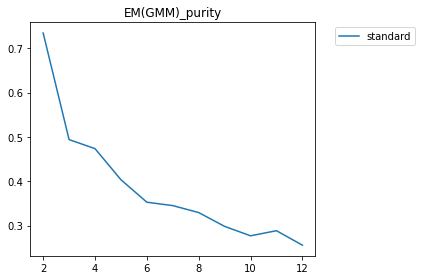

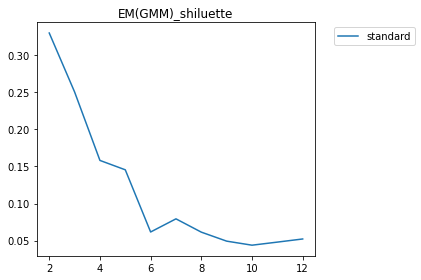

The DBSCAN purity score for 10 min_samples is 0.734641472868217
The DBSCAN silhouette score for 10 min_samples is 0.8539702946571924
The DBSCAN purity score for 20 min_samples is 0.734641472868217
The DBSCAN silhouette score for 20 min_samples is 0.8528652172290639
{'standard': [[0.734641472868217, 0.734641472868217]]}


ValueError: x and y must have same first dimension, but have shapes (2,) and (1, 2)

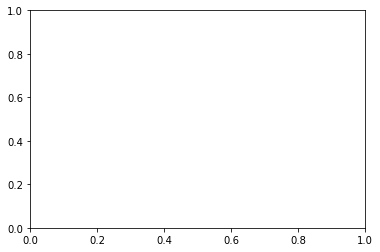

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
import seaborn as sns
from pyclustering.cluster.clarans import clarans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster import cluster_visualizer_multidim, elbow
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.metrics.cluster import contingency_matrix, silhouette_score
from pyclustering.cluster.silhouette import silhouette
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
#The k-Means algorithm is not applicable to categorical data, as categorical variables are discrete and do not have any natural origin. 
#So computing euclidean distance for such as space is not meaningful.
#We should cluster computing with Euclidean and Manhatthan distance.So we will skip encoding this time

Mkmeans_purity= {}
Mkmeans_shiluette= {}
Mkmenas_elbow = {}
Ekmeans_purity= {}
Ekmeans_shiluette= {}
Ekmenas_elbow = {}
EM_purity= {}
EM_shiluette= {}
DBSCAN_purity= {}
DBSCAN_shiluette= {}
AP_purity= {}
AP_shiluette= {}
CLA_purity= {}
CLA_shiluette= {}
  
def ordinal_encoder(data,feature,feature_rank):
    
    ordinal_dict = {}
    
    for i, feature_value in enumerate(feature_rank):
        ordinal_dict[feature_value]=i+1
    
    data[feature] = data[feature].map(lambda x: ordinal_dict[x])
    
    return data

def clusterToIdx(clusters):
    idx_list = [-1 for i in range(0, 20640)]
    idx = 0

    for k in clusters:
        for i in k:
            idx_list[i] = idx
        idx = idx + 1

    return idx_list


def divide_house_value(data, k):
    data['label'] = pd.cut(data["median_house_value"], k, labels = range(1, k+1))
    return data['label']

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    confusion_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

def encode(encoder_name, data):
    if encoder_name == "one-hot":
        one_hot = pd.get_dummies(data['ocean_proximity'])
        data = pd.concat([data, one_hot],axis = 1)
        data.drop('ocean_proximity',axis = 1, inplace = True)

    elif encoder_name == "ordinal":
        data = ordinal_encoder(data, 'ocean_proximity', ['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'])
    else: print("The encoder is not defined")
    return data

def scaling(scaler_name, data):
    if scaler_name == "standard":
        data = StandardScaler().fit_transform(data)
    elif scaler_name == "minmax":
        data = MinMaxScaler().fit_transform(data)
    elif scaler_name == "robust":
        data = RobustScaler().fit_transform(data)
    elif scaler_name == "Maxabs":
        data = MaxAbsScaler().fit_transform(data)
    elif scaler_name == "normalize":
        data = Normalizer().fit_transform(data)
    else: print("The scaler is not defined")
    return data

def modeling(model_name, data, k, dist, y, measure_tool_list, hyperparameter_list):
    if model_name == "K-means":
        initial_centers = random_center_initializer(data, k, random_state=5).initialize()
        model = kmeans(data, initial_centers=initial_centers, metric=dist)
        model.process()
    # cluster analysis results - clusters and centers
        pyClusters = model.get_clusters()
        pyCenters = model.get_centers()
        # enumerate encoding type to index labeling to get labels
        pyEncoding = model.get_cluster_encoding()
        pyEncoder = cluster_encoder(pyEncoding, pyClusters, data)
        pyLabels = pyEncoder.set_encoding(0).get_clusters()
        print(f"The K-means purity score with {k} clusters is {purity_score(y, pyLabels)}")
        print(f"The K-means silhouette score with {k} clusters is {silhouette_score(data, pyLabels, metric='manhattan')}")
        return purity_score(y, pyLabels), silhouette_score(data, pyLabels, metric='manhattan')
        #score, plot

    elif model_name == "EM(GMM)":
        gmm = GaussianMixture(n_components=k)
        labels = gmm.fit_predict(data)
        print(f"The EM(GMM) purity score with {k} clusters is {purity_score(y, labels)}")
        print(f"The EM(GMM) silhouette score with {k} clusters is {silhouette_score(data, labels, metric='manhattan')}")
        return purity_score(y, labels), silhouette_score(data, labels, metric='manhattan')
        #score, plot
        #plot = plt.subplot(2, 1, 1 + index)
    elif model_name == "CLARANS":
        tdata = np.array(data)
        tdata = tdata.tolist()
        max_sum=0
        
        clarans_instance = clarans(tdata, k, 6, 4)
        clusters = clarans_instance.get_clusters()
        labels = clusterToIdx(clusters)

        print(f"The CLARANS purity score for {k} clusters is {purity_score(y, labels)}")
        print(f"The CLARANS silhouette score with {k} clusters is {silhouette_score(data, labels, metric='manhattan')}")
        return purity_score(y, labels), silhouette_score(data, labels, metric='manhattan')
        #score, plot
    elif model_name == "DBSCAN":
        min_samples = hyperparameter_list['DBSCAN']
        silhouette = []
        purity = []
        for m in min_samples:
            dbscan = DBSCAN(eps=5, min_samples=m)
            labels = dbscan.fit_predict(data)
            #score, plot
            print(f"The DBSCAN purity score for {m} min_samples is {purity_score(y, labels)}")
            print(f"The DBSCAN silhouette score for {m} min_samples is {silhouette_score(data, labels, metric='manhattan')}")
            purity.append(purity_score(y, labels))
            silhouette.append(silhouette_score(data, labels, metric='manhattan'))
        return purity, silhouette
    elif model_name == "AffinityPropagation":
        clustering = AffinityPropagation(random_state=5).fit(data)
        labels = clustering.predict(data)
        print(f"The AffinityPropagation purity score for {k} clusters is {purity_score(y, labels)}")
        print(f"The AffinityPropagation silhouette score with {k} clusters is {silhouette_score(data, labels, metric='manhattan')}")
        return purity_score(y, labels), silhouette_score(data, labels, metric='manhattan')
        #score, plot
    else: print("The model is not defined")
    return 
#AutoML function
def AutoML(scaler_list, encoder_list, model_list, measure_tool_list,hyperparameter_list,dataset, median_house_value):
    for scaler in scaler_list:
        scaled_data = scaling(scaler, dataset)
        print(f"****Scaler { scaler }*****")
        #plt만들기 
        for model_name in model_list:
            shiluette= []
            purity = []
            elbow = []
            for k in range(2, 13):
                #distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 'canberra': 5, 'chi-square':
                euclidean_metric = distance_metric(0)
                manhattan_metric = distance_metric(2) 
                y = divide_house_value(median_house_value, k)
                if(model_name == "K-means"): 
                    print("****K-means With ManHattan")
                    model_purity, model_shiluette = modeling(model_name, scaled_data, k, manhattan_metric, y, measure_tool_list, hyperparameter_list)
                    shiluette.append(model_shiluette)
                    purity.append(model_purity)
                    
                    #elbow.append(model_elbow)
                if(model_name == "K-means"):
                    print("****K-means With Euclid")
                    model_purity, model_shiluette = modeling(model_name, scaled_data, k, euclidean_metric, y, measure_tool_list, hyperparameter_list)
                    #elbow.append(model_elbow)
                else:
                    model_purity, model_shiluette = modeling(model_name, scaled_data, k, euclidean_metric, y, measure_tool_list, hyperparameter_list)
                shiluette.append(model_shiluette)
                purity.append(model_purity)  
                if(model_name == "DBSCAN"):#DBSCAN doesn't need k
                    break;
            if model_name == "K-means":
                #Mkmeans_elbow[scaler] = elbow[::2]
                #Ekmenas_elbow[scaler] = elbow[1::2]
                Mkmeans_purity[scaler]=purity[::2]
                print(Mkmeans_purity)
                Ekmeans_purity[scaler]=purity[1::2]
                Mkmeans_shiluette[scaler]=shiluette[::2]
                Ekmeans_shiluette[scaler]=shiluette[1::2]
                #makeplot("Manhattan KMeans_elbow", Mkmeans_elbow, range(2, 13))
                #makeplot("Euclid KMeans_elbow", Ekmeans_elbow, range(2, 13))
                makeplot("Manhattan KMeans_purity", Mkmeans_purity, range(2, 13))
                makeplot("Euclid KMeans_purity", Ekmeans_purity, range(2, 13))
                makeplot("Manhattan KMeans_shiluette", Mkmeans_shiluette, range(2, 13))
                makeplot("Euclid KMeans_shiluette", Ekmeans_shiluette, range(2, 13))
            elif model_name == "EM(GMM)":
                EM_purity[scaler]=purity
                EM_shiluette[scaler]=shiluette
                print(EM_purity)
                makeplot("EM(GMM)_purity", EM_purity, [2,3,4,5,6,7,8,9,10,11,12])
                makeplot("EM(GMM)_shiluette", EM_shiluette, range(2, 13))
            elif model_name == "DBSCAN":
                DBSCAN_purity[scaler]=purity
                DBSCAN_shiluette[scaler]=shiluette
                print(DBSCAN_purity)
                makeplot("DBSCAN_purity", DBSCAN_purity, [10, 20])
                makeplot("DBSCAN_shiluette", DBSCAN_shiluette,[10, 20])
            elif model_name == "AffinityPropagation":
                AP_purity[scaler]=purity
                AP_shiluette[scaler]=shiluette
                makeplot("AP_purity", AP_purity, range(2, 13))
                makeplot("AP_shiluette", AP_shiluette, range(2, 13))
            elif model_name == "CLARANS":
                CLA_purity[scaler]=purity
                CLA_shiluette[scaler]=shiluette
                makeplot("CLA_purity", CLA_purity, range(2, 13))
                makeplot("CLA_shiluette", CLA_shiluette, range(2, 13))
            #한 모델에 대한 2~13 plot 하나씩추가

def makeplot(title, dict, x_list):
    for key, value in dict.items():
        plt.plot(x_list, value, label=key)

    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
    plt.tight_layout()
    plt.show()
         
def main():
    dataset = pd.read_csv('./housing.csv') #load dataset
    
    #****Data exploration****
    print(dataset.describe())#Each columns have too different standrad deviation It needs to be scaled
    print(dataset.isna().sum()) #total_bedrooms have NaN values.
    print(dataset.info()) #ocean_proximity column is categorical variable. It needs to be encoded
    
    #****Data cleaning****
    #Drop axis
    data = dataset.drop(columns=["median_house_value"])
    #fill NaN value
    data["total_bedrooms"] = data["total_bedrooms"].fillna(0)
    
    #****feature engineering****
    #split median_house_value
    median_house_value = pd.DataFrame(dataset["median_house_value"])
    #new column "population_in_households"
    #The k-Means algorithm is not applicable to categorical data, as categorical variables are discrete and do not have any natural origin. 
    #So computing euclidean distance for such as space is not meaningful.
    #We should cluster computing with Euclidean and Manhatthan distance.So we will skip encoding this time. 
    #drop categorical variahble
    data = data.drop(columns=["ocean_proximity"])
    
    #sns.heatmap(data,annot=True)
    hyperparameter_list={
        'DBSCAN':[10, 20]
    }
    scaler_list = ["standard", "minmax", "robust", "Maxabs", "normalize"]
    encoder_list= ["one-hot", "ordinal"]
    model_list = ["EM(GMM)", "DBSCAN", "AffinityPropagation", "CLARANS"]
    measure_tool_list = ["Silhouette", "elbow", 'purity']
    AutoML(scaler_list, encoder_list, model_list, measure_tool_list, hyperparameter_list, data, median_house_value)
main()
#추가해야하는것 1. elbow, 2. Affinity propagation, 3. CLARANS, 4. main에 다른 column합친걸로 돌려보기 5. 전체 cluster plot

In [19]:
elif(model_name=="EM(GMM)"):
                    for tool_name in measure_tool_list:
                        if(tool_name == "Silhouette"):
                        elif(tool_name == "purity"):
                        else:
                            print("The Measure tool is not defined")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 166)

In [ ]:
# function purity score is defined in previous section
        #for tool_name in measure_tool_list:
         #   if(tool_name == "purity"):
         #       print(f"The purity score for Manhattan distance is {purity_score(y, pyLabels)*100, 2}%")
        #kmeans_visualizer.show_clusters(data, pyClusters, pyCenters)
        #score = silhouette_score(data, pyLabels, metric='euclidean')
        #print('Silhouetter Score: %.3f' % score)
        #return purity_score(y, pyLabels)

In [ ]:
from cv2 import kmeans
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, AffinityPropagation
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.clarans import clarans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from pyclustering.utils import timedcall
from sklearn import metrics

def sub_list(a: list, b: list) -> list:
    result = []
    for item in a:
        if item not in b: result.append(item)
    return result


def encodeNscale(X: pd.DataFrame, encode_col: list, scale_col: list) -> list:
    """
    return 8 combinations encoding and scaling dataframe list
    combination order:
    (0~3)ordinal -> stdard, maxabs, minmax, robust
    (4~8)onehot -> stdard, maxabs, minmax, robust

    param
    --------
    X: original data
    encode_col: to encode columns list
    scale_col: to scale columns list

    return
    -------------
    list: 8 combinations encoding and scaling dataframe list

    """
    scalers = [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), RobustScaler()]
    X_list = []
    encoded = []
    scaled = []

    if encode_col != None and len(encode_col) != 0:
        # encoding: ordinal
        temp_data = OrdinalEncoder().fit_transform(X[encode_col])
        temp_data = pd.DataFrame(temp_data, columns=encode_col)
        encoded.append(temp_data)

        # encoding: one hot
        temp_data = pd.get_dummies(data=X[encode_col], columns=encode_col)
        if is_sampling:
            temp_data['new_index'] = np.array(list(range(0, N_sampling)))  # sampling 안하면 주석처리
            temp_data.set_index('new_index', inplace=True)  # sampling 안하면 주석처리
        encoded.append(temp_data)

    if scale_col != None and len(scale_col) != 0:
        # scaling
        for scaler in scalers:
            temp_data = pd.DataFrame(scaler.fit_transform(X[scale_col]), columns=scale_col)
            scaled.append(temp_data)

    # combine encoding data and scaling data
    if len(encoded) == 0: return scaled
    if len(scaled) == 0: return encoded
    for e in encoded:
        for s in scaled:
            temp_data = pd.concat([e, s], axis=1)
            X_list.append(temp_data)

    return X_list


def findBestClust(X_list: list, y, models: list, params: list) -> str:
    """
    find best combination that highest accuracy model, scaling, encoding, parameters
    return string that have best score, model, parameter, scale and encode index

    param
    ------------
    X_list: dataset which encoding and scaling
    y: target or origin cluster
    models: list of models name
    params: dict of input of grid search

    return
    -----------
    str: result string that include gridsearch score, purity score, silhouette score information
    """
    model = None
    best_score = None
    best_score_param = None
    best_score_model = None
    best_score_x = None
    best_score_pred = None

    best_silhouette = None
    best_silhouette_param = None
    best_silhouette_model = None
    best_silhouette_x = None
    best_silhouette_pred = None

    best_purity = None
    best_purity_param = None
    best_purity_model = None
    best_purity_x = None
    best_purity_pred = None

    for enum_model in enumerate(models):
        param = params[enum_model[0]]
        model_name = str(enum_model[1]).lower()
        # CLARANS
        if model_name in ['clarans']:
            for enum_x in enumerate(X_list):
                cldata = enum_x[1].values.tolist()
                for num_cluster in param['number_clusters']:
                    for num_local in param['numlocal']:
                        for max_nb in param['maxneighbor']:
                            cl_instance = clarans(cldata, num_cluster, num_local, max_nb)
                            cl_instance.process()
                            # make pred array
                            pred = np.zeros((len(cldata)))
                            i = 1
                            for c in cl_instance.get_clusters():
                                for node in c:
                                    pred[node] = i
                                i += 1
#                             print(pred)
#                             print(cldata)
                            # calculate silhouette
                            
                            silhouette = silhouette_score(cldata, pred, metric='euclidean')
                            if best_silhouette == None or best_silhouette < silhouette:
                                best_silhouette = silhouette
                                best_silhouette_param = {'number_clusters': num_cluster, 'numlocal': num_local,
                                                         'maxneighbor': max_nb}
                                best_silhouette_model = 'clarans()'
                                best_silhouette_x = enum_x[0]
                                best_silhouette_pred = pred

            continue
        # DBSCAN
        elif model_name in ['dbscan']:
            model = DBSCAN()
            for enum_x in enumerate(X_list):
                for eps in param['eps']:
                    for min_sample in param['min_samples']:
                        for alg in param['algorithm']:
                            
                            dbscan = DBSCAN(eps=eps, min_samples=min_sample, algorithm=alg)
                            enum_list=enum_x[1].values.tolist()
                            #pred = dbscan.fit_predict(enum_x[1])
                            pred=np.zeros((len(dbscan.fit_predict(enum_x[1]))))
                            i=1
                            for c in cl_instance.get_clusters():
                                for node in c:
                                    pred[node]=i
                                i+=1
                            silhouette = silhouette_score(enum_list, pred, metric='euclidean')
                            if best_silhouette == None or best_silhouette < silhouette:
                                best_silhouette = silhouette
                                best_silhouette_param = {'eps': eps, 'min_samples': min_sample, 'algorithm': alg}
                                best_silhouette_model = DBSCAN(eps, min_sample, algorithm=alg)
                                best_silhouette_x = enum_x[0]
                                best_silhouette_pred = pred
                            # calculate silhouette
                            #enum_list=enum_x[1].values.tolist()
                            #print(enum_list)
                            #print(pred)
                            
            continue

        else:
            # K-means
            if model_name in ['kmeans', 'k-means']:
                model = KMeans()
            # GMM
            elif model_name in ['em', 'gmm', 'gaussianmixture', 'gaussian mixture']:
                model = GaussianMixture()
            # Affinity Propagation
            elif model_name in ['affinitypropagation', 'affinity propagation']:
                model = AffinityPropagation()

        # fitting model using by grid search cv
        for enum_x in enumerate(X_list):
            scv = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1,
                               cv=3, scoring='homogeneity_score')
            scv.fit(enum_x[1], y)
            pred = scv.predict(enum_x[1])

            if best_score == None or best_score < scv.best_score_:
                best_score = scv.best_score_
                best_score_param = scv.best_params_
                best_score_model = scv.best_estimator_
                best_score_x = enum_x[0]
                best_score_pred = pred

            # calculate silhouette
            silhouette = silhouette_score(enum_x[1], pred, metric='euclidean')
            if best_silhouette == None or best_silhouette < silhouette:
                best_silhouette = silhouette
                best_silhouette_param = scv.best_params_
                best_silhouette_model = scv.best_estimator_
                best_silhouette_x = enum_x[0]
                best_silhouette_pred = pred

            cm = contingency_matrix(y, pred)
            purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)
            if best_purity == None or best_purity < purity:
                best_purity = purity
                best_purity_param = scv.best_params_
                best_purity_model = scv.best_estimator_
                best_purity_x = enum_x[0]
                best_purity_pred = pred

        if model_name in ['kmeans', 'k-means']:
            dst = []
            for k in range(3, 10):
                kmeans = KMeans(n_clusters=k)
                kmeans.fit(X_list[0])
                dst.append(kmeans.inertia_)
            distortion.append(dst)

    # return best result

    if best_score != None:
        if len(X_list[best_score_x].columns) == 3:
            plotModel3D(1, X_list[best_score_x].iloc[:, [0]], X_list[best_score_x].iloc[:, [1]],
                        X_list[best_score_x].iloc[:, [2]], best_score_pred, 'best_score result')
        elif len(X_list[best_score_x].columns) == 2:
            plotModel2D(1, X_list[best_score_x].iloc[:, [0]], X_list[best_score_x].iloc[:, [1]], best_score_pred,
                        'best_score result')
    if best_purity != None:
        if len(X_list[best_purity_x].columns) == 3:
            plotModel3D(1, X_list[best_purity_x].iloc[:, [0]], X_list[best_purity_x].iloc[:, [1]],
                        X_list[best_purity_x].iloc[:, [2]], best_purity_pred, 'best_purity result')
        elif len(X_list[best_purity_x].columns) == 2:
            plotModel2D(1, X_list[best_purity_x].iloc[:, [0]], X_list[best_purity_x].iloc[:, [1]], best_purity_pred,
                        'best_purity result')
    if best_silhouette != None:
        if len(X_list[best_silhouette_x].columns) == 3:
            plotModel3D(1, X_list[best_silhouette_x].iloc[:, [0]], X_list[best_silhouette_x].iloc[:, [1]],
                        X_list[best_silhouette_x].iloc[:, [2]], best_silhouette_pred, 'best_silhouette result')
        elif len(X_list[best_silhouette_x].columns) == 2:
            plotModel2D(1, X_list[best_silhouette_x].iloc[:, [0]], X_list[best_silhouette_x].iloc[:, [1]],
                        best_silhouette_pred, 'best_silhouette result')

    result1 = 'best score: {}, param: {}, model: {}, x: {}'.format(best_score, best_score_param, best_score_model,
                                                                   best_score_x)
    result2 = 'best silhouette: {}, param: {}, model: {}, x: {}'.format(best_silhouette, best_silhouette_param,
                                                                        best_silhouette_model, best_silhouette_x)
    result3 = 'best purity: {}, param: {}, model: {}, x: {}'.format(best_purity, best_purity_param, best_purity_model,
                                                                    best_purity_x)
    return result1 + '\n' + result2 + '\n' + result3


def plotModel2D(fig_num: int, x, y, colormap, title: str) -> None:
    plt.figure()
    plt.scatter(x, y, c=colormap, cmap=plt.cm.Set1)
    plt.title(title)


def plotModel3D(fig_num: int, x, y, z, colormap, title: str) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z, c=colormap, cmap=plt.cm.Set1)
    plt.title(title)


def plotElbow(fig_num: int, x: list, title: str) -> None:
    plt.figure(figsize=(16, 8))
    plt.plot(list(range(3, 10)), x, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(title)


# -------------------------------------------------------------------------------
# End Function Definition
# Strat __main__
# -------------------------------------------------------------------------------

# read data
N_sampling = 20
is_sampling = True
data = pd.read_csv('dataset\housing.csv')
if is_sampling:
    data = data.sample(n=N_sampling, random_state=1)  # sampling 

# preprocessing - fill NaN in total_bedrooms
data.fillna(method='bfill', axis=0, inplace=True)
data['total_bedrooms'] = data['total_bedrooms'].astype(float)

# preprocessing - ocean_proximity 
data['ocean_proximity'] = data['ocean_proximity'].astype("category")

# preprocessing - change median_house_value to 5 quantiles
quantiles = list(data['median_house_value'].quantile([0, 0.2, 0.4, 0.6, 0.8]))
for eq in enumerate(quantiles):
    data.loc[data['median_house_value'] >= eq[1], 'median_house_cate'] = eq[0]
data['median_house_cate'] = data['median_house_cate'].astype("category")

# -------------------------------------------------------------------------------
# End Preprocessing
# Strat Encoding and Scaling
# -------------------------------------------------------------------------------

# set masks
encode_mask = ['ocean_proximity']
scale_mask = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income']

# set y and various feature Combination
y = data['median_house_value']
feature_Combi = {}
feature_Combi['all'] = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                        'total_bedrooms', 'population', 'households', 'median_income',
                        'ocean_proximity']
feature_Combi['Loc'] = ['longitude', 'latitude', 'ocean_proximity']
feature_Combi['Loc&Pop'] = ['longitude', 'latitude', 'population']
feature_Combi['House_info'] = ['housing_median_age', 'total_rooms', 'total_bedrooms']
feature_Combi['House_hold_info'] = ['households', 'median_income']

# encoding and scaling
Xdataset = {}
for key in feature_Combi:
    encode_col = sub_list(feature_Combi[key], scale_mask)
    scale_col = sub_list(feature_Combi[key], encode_mask)
    Xdataset[key] = encodeNscale(data[feature_Combi[key]], encode_col, scale_col)

    # for ens_result in Xdataset[key]: # print encode and scale result
    #     print(ens_result)

# -------------------------------------------------------------------------------
# End Encoding and Scaling
# Strat Analyzing
# -------------------------------------------------------------------------------

# set models and params
models = []
params = []
distortion = []

models.append('kmeans') # kmeans
params.append({'n_clusters': [3,5,7,10], 'algorithm': ['full', 'elkan']})

models.append('gmm') #EM(GMM)
params.append({'n_components': [3,5,7,10], 
              'covariance_type': ['full', 'tied'],
               'tol': [1e-2, 1e-3, 1e-4]})

models.append('clarans')
params.append({'number_clusters': [3,5,7,10], 
              'numlocal': [1,3,5],
               'maxneighbor': [3,4]})

models.append('dbscan') # DBSCAN
params.append({'eps': [0.5,0.8], 'min_samples': [10,15], 'algorithm': ['ball_tree', 'kd_tree']})

models.append('AffinityPropagation')  # affinity propagation
params.append({'damping': [0.7, 0.65, 0.75]})

total_result = ''
for Xlist_key in Xdataset.keys():
    total_result += '\n' + Xlist_key + '\n'
    total_result += findBestClust(Xdataset[Xlist_key], y, models, params)
print(total_result)  # print result

plt.show()